# Modelo

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from glob import glob
import numpy as np
from numpy.linalg import inv
import os
import shutil
import random
import cv2
import gc
import matplotlib.pyplot as plt
from itertools import zip_longest
import uuid
from multiprocessing import Pool, cpu_count

%matplotlib inline

## División de train / validation

Dividimos el dataset de imágenes en dos conjuntos, uno de entrenamiento y otro de validación.

In [3]:
DATA_DIR = os.path.join('e:', 'Facultad', 'vc')

In [4]:
X = glob(os.path.join(DATA_DIR, 'test2017', '*.jpg'))

In [5]:
len(X), X[0]

(40670, 'e:Facultad\\vc\\test2017\\000000000001.jpg')

In [6]:
def train_test_split(X, test_size=0.2):
    n_test = round(len(X) * test_size)
    random.shuffle(X)
    test_samples, train_samples = X[:n_test], X[n_test:]
    return train_samples, test_samples

In [7]:
X_train, X_val = train_test_split(X, test_size=0.05)
len(X_train), len(X_val)

(38636, 2034)

## Generación de imágenes

Primero definimos los siguientes parámetros:

In [8]:
WIDTH, HEIGHT = 320, 240
RHO = 32
PATCH_SIZE = 128

A continuación se define la función `process_image` que, dadda una imagen, extrae dos imágenes con un parche aleatorio, y su correspondiente vector 8x1 que representa la homografía que relaciona ambas imágenes.

In [35]:
def random_patch_positions():
    """Calculate random position for patch P"""
    px = random.randint(RHO, WIDTH - PATCH_SIZE - RHO)
    py = random.randint(RHO, HEIGHT - PATCH_SIZE - RHO)
    return px, py  

def random_delta():
    """Calculate random delta for patch corner distortion"""
    return np.random.randint(-RHO, RHO, size=2)

def extract_from_patch(img, patch):
    """Extract patch from image"""
    a, _, c, _ = patch
    return img[a[1]:c[1], a[0]:c[0]]

def build_random_patch():
    px, py = random_patch_positions()
    return [(px, py),
            (px + PATCH_SIZE, py),
            (px + PATCH_SIZE, py + PATCH_SIZE),
            (px, py + PATCH_SIZE)]

def distort_patch(patch):
    return [p + random_delta() for p in patch]


def warp_image(img, patch, new_patch):
    # Get homography matrix
    H = cv2.getPerspectiveTransform(
        np.float32(patch),
        np.float32(new_patch))
    
    # Transform image with H
    return cv2.warpPerspective(img, inv(H),
        (img.shape[1], img.shape[0]))  

def process_image(img, debug=False):
    # Resize and convert to grayscale
    resized_img = cv2.resize(img, (WIDTH, HEIGHT))
    if len(resized_img.shape) == 3:
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = resized_img
        
    assert(len(gray_img.shape) == 2)
 
    # Build patch, and perturb corners
    patch = build_random_patch()
    distorted_patch = distort_patch(patch)

    warped_img = warp_image(gray_img, patch, distorted_patch)
    
    # Extract patches
    a_img = extract_from_patch(gray_img, patch)
    b_img = extract_from_patch(warped_img, patch)
    
    # Stack patch images together
    x = np.dstack([a_img, b_img])
    
    # Subtract patches to get delta
    # int8 is good enough because RHO = 32, so, values are in [-32, 32] range
    y = np.subtract(patch, distorted_patch).ravel().astype(np.int8)

    if debug:
        # On debug mode, return also original patch and warped img for plotting
        return x, y, (patch, distorted_patch), (gray_img, warped_img)
    
    return x, y

Vamos a plotear y ver los resultados de la función para corroborar que funciona correctamente:

In [36]:
def plot_processed_image(img_path):
    img = plt.imread(img_path)
    x, y, patches, imgs = process_image(img, debug=True)
    
    print('Label: {}'.format(y))
    
    for i in range(2):
        plt.subplot(2, 2, i+1)
        plt.grid(False)    
        temp_img = cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2RGB)
        cv2.polylines(temp_img, np.int32([patches[i]]), 1, (255, 0, 0), thickness=2)    
        plt.imshow(temp_img, cmap='gray')

    for i in range(2):
        patch_img = x[:, :, i]
        
        print('[{}] shape={}'.format(i, patch_img.shape))        
        print('[{}] mean={}, std={}'.format(
            i, np.mean(patch_img), np.std(patch_img)))
      
        plt.subplot(2, 2, i+3)
        plt.grid(False)
        plt.imshow(patch_img, cmap='gray')
        #plt.text(0.5,0.5, str((2, 2, i)), ha=’center’, fontsize = 10)
        plt.tight_layout()

Label: [-21  18  14  -3  13  -1  -2  26]
[0] shape=(128, 128)
[0] mean=159.33258056640625, std=41.66305297777117
[1] shape=(128, 128)
[1] mean=159.66070556640625, std=40.926675022635614


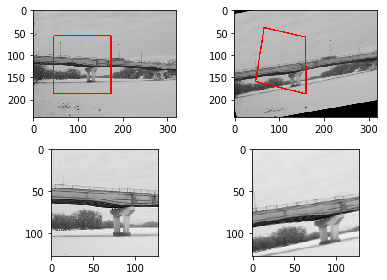

In [37]:
plot_processed_image(X_train[0])

Label: [-20  22  -2 -26  23  -9  -7 -30]
[0] shape=(128, 128)
[0] mean=120.85919189453125, std=45.35679553390845
[1] shape=(128, 128)
[1] mean=121.07745361328125, std=43.16989759157063


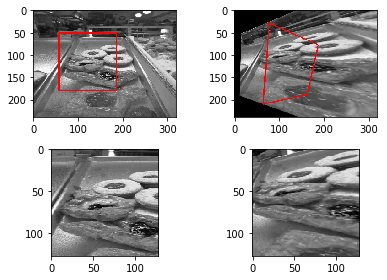

In [38]:
plot_processed_image(X_train[10])

Ahora, recorremos todas las imágenes del dataset de COCO en bloques de 1000 imágenes, procesamos cada imágen 10 veces y guardamos los resultados en formato "(X, y)" en archivos `.npz`. Cada uno de estos archivos tendrá a lo sumo 10.000 muestras etiquetadas.

In [39]:
NUM_SAMPLES_PER_IMAGE = 10
NUM_SAMPLES_PER_ARCHIVE = 10000

NUM_IMAGES_PER_ARCHIVE = NUM_SAMPLES_PER_ARCHIVE // NUM_SAMPLES_PER_IMAGE

In [40]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def generate_dataset_archives(dirname, n_jobs=cpu_count()):
    if os.path.exists(dirname):
        print('{} already exists! Delete it if you want to regenerate archives.'.format(dirname))
        return
    
    datasets = dict(train=X_train, val=X_val)

    for key, X_set in datasets.items():
        random.shuffle(X_set)
        
        for img_group in grouper(X_set, NUM_IMAGES_PER_ARCHIVE):
            xs, ys = [], []

            for img_path in img_group:
                if img_path:
                    for i in range(NUM_SAMPLES_PER_IMAGE):
                        img = plt.imread(img_path)
                        try:
                            x, y = process_image(img)
                        except:
                            print("Image broken? {}".format(img_path))
                            raise
                        xs.append(x)
                        ys.append(y)

            xs = np.array(xs, dtype=np.uint8)
            ys = np.array(ys, dtype=np.uint16)
            
            outfile = os.path.join(dirname, key, '{}.npz'.format(uuid.uuid4()))
            os.makedirs(os.path.dirname(outfile), exist_ok=True)
            np.savez_compressed(outfile, x=xs, y=ys)
            print(outfile)

In [ ]:
generate_dataset_archives(os.path.join(DATA_DIR, 'dataset'))

e:Facultad\vc\dataset\train\5bdae53e-0787-4f26-9635-1866b44cee01.npz
e:Facultad\vc\dataset\train\91274394-7500-4ea8-bf0a-fbad906caae7.npz
e:Facultad\vc\dataset\train\510834e8-553a-4a35-8579-abab9a31c102.npz


## *Data generators* y preprocesamiento

In [89]:
def preprocess_features(x):
    # Rescale images
    x = x / 255.0
    # Sample-wise centering
    x -= np.mean(x, axis=0, keepdims=True)
    # Sample-wise std normalization
    x /= (np.std(x, axis=0, keepdims=True) + 1e-7)    
    return x

def preprocess_labels(y):
    # Rescale
    y = y / RHO
    return y

def build_data_generator(path, batch_size=64):
    while True:
        files = glob(os.path.join(path, '*.npz'))
        random.shuffle(files)
        
        for npz in files:
            archive = np.load(npz)
            xs = archive['x']
            ys = archive['y']

            # Yield minibatches
            for i in range(0, len(xs), batch_size):
                end_i = min(i + batch_size, len(xs))
                xs_batch = xs[i:end_i]
                ys_batch = ys[i:end_i]
                
                # Preprocess features and labels
                xs_batch = preprocess_features(xs_batch)
                ys_batch = preprocess_labels(ys_batch)

                yield xs_batch, ys_batch

In [90]:
TRAIN_DIR = os.path.join(DATA_DIR, 'dataset', 'train')
VAL_DIR = os.path.join(DATA_DIR, 'dataset', 'val')

In [91]:
gen = build_data_generator(TRAIN_DIR)

In [92]:
xs, ys = next(gen)

In [93]:
len(xs), len(ys)

(64, 64)

In [94]:
xs[0].shape, ys[0].shape

((128, 128, 2), (8,))

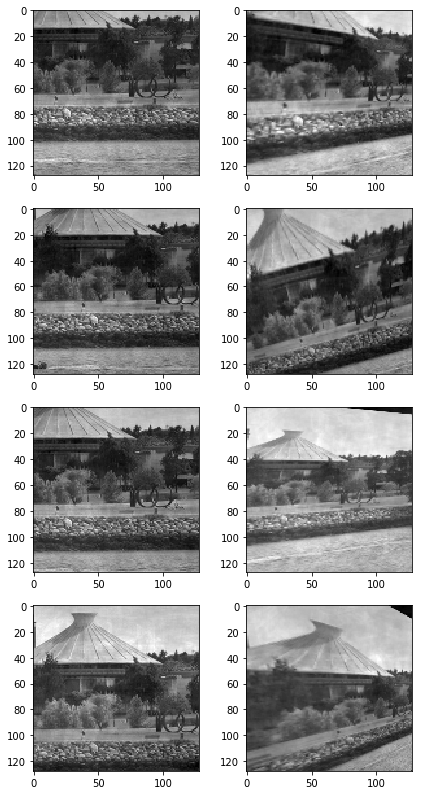

In [95]:
plt.figure(figsize=(7,7*2))

for i in range(4):
    img_a = xs[i][:, :, 0]
    plt.subplot(4, 2, (i*2)+1)
    plt.grid(False)
    plt.imshow(img_a, cmap='gray')
    #plt.tight_layout()
    
    img_b = xs[i][:, :, 1]
    plt.subplot(4, 2, (i*2)+2)
    plt.grid(False)
    plt.imshow(img_b, cmap='gray')
    #plt.tight_layout()    

## Definición del Modelo

In [118]:
def euclidean_l2_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

def mace(y_true, y_pred):
    """Mean Average Corner Error metric"""
    return K.mean(RHO * K.sqrt(K.sum(K.square(K.reshape(y_pred, (-1,4,2)) - K.reshape(y_true, (-1,4,2))), \
        axis=-1, keepdims=True)), axis=1)  

def homography_regression_model():
    input_shape = (128, 128, 2)
    filters = 64
    kernel_size = (3, 3)
    conv_strides = (1, 1)
    max_pool_size = (2, 2)
    max_pool_strides = (2, 2)
    
    input_img = Input(shape=input_shape)
     
    x = Conv2D(filters, kernel_size, strides=conv_strides, padding='same', name='conv1', activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, strides=conv_strides, padding='same', name='conv2', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x)
    
    x = Conv2D(filters, kernel_size, strides=conv_strides, padding='same', name='conv3', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = Conv2D(filters, kernel_size, strides=conv_strides, padding='same', name='conv4', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(x)
   
    x = Conv2D(filters*2, kernel_size, strides=conv_strides, padding='same', name='conv5', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = Conv2D(filters*2, kernel_size, strides=conv_strides, padding='same', name='conv6', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3')(x)
    
    x = Conv2D(filters*2, kernel_size, strides=conv_strides, padding='same', name='conv7', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = Conv2D(filters*2, kernel_size, strides=conv_strides, padding='same', name='conv8', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)    
    x = Dense(1024, name='fc1', activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(8, name='fc2', activation=None)(x)
    
    model = Model(inputs=input_img, outputs=[out])
    
    model.compile(optimizer=SGD(lr=0.005, momentum=0.9),
                  loss=euclidean_l2_loss,
                  metrics=['mse', mace])

    return model

In [119]:
model = homography_regression_model()

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 2)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 64)        36928     
__________

## Entrenamiento

In [ ]:
batch_size = 64
total_iterations = 90000

steps_per_epoch = len(X_train) // batch_size
epochs = total_iterations // steps_per_epoch

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', verbose=1)

train_generator = build_data_generator(TRAIN_DIR, batch_size)
val_generator = build_data_generator(VAL_DIR, batch_size)

history = model.fit_generator(train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    callbacks = [reduce_lr])

In [ ]:
model.save('model.h5')

---

In [117]:
# Correr esto para liberar memoria
K.clear_session()
del model
gc.collect()

590